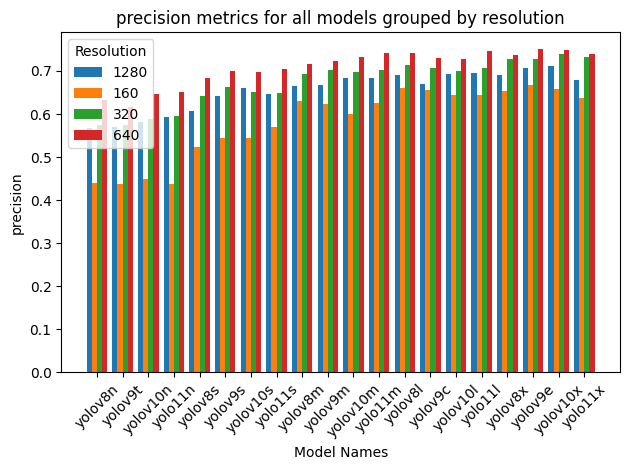

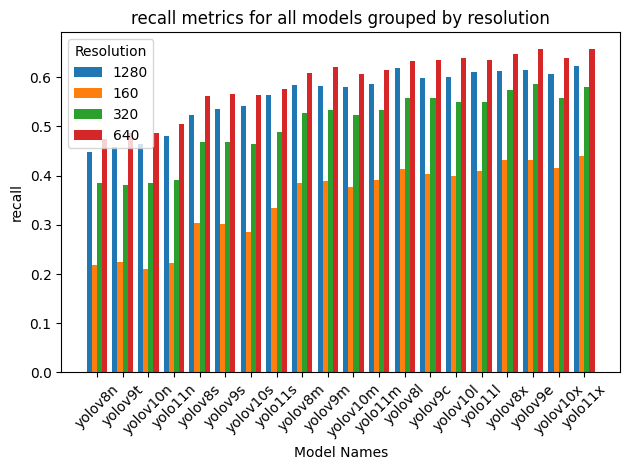

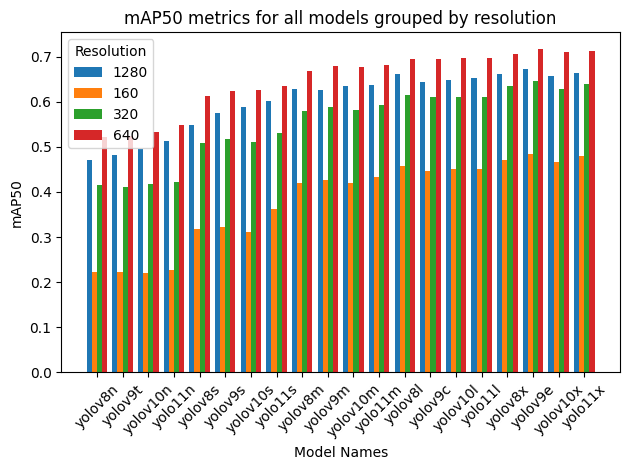

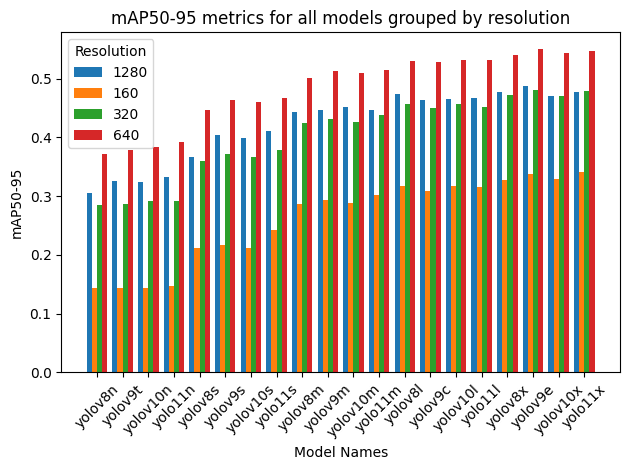

In [7]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import re

# Define the folder containing the JSON files
results_folder = '../yolo_eval/results'

# Metrics to be plotted
metrics = ["metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)"]

# Initialize a dictionary to hold all metrics grouped by resolution
metric_data = {metric: {} for metric in metrics}


def unify_model_names(model_name: str) -> str:
    # Make naming conventions consistent across yolo versions
    model_name = model_name.replace("yolov", "yolo")
    model_name = model_name.replace("9t", "9n").replace("9c", "9l").replace("9e",
                                                                            "9x")  # Yolov9 has different model names
    return model_name


def _sort_key_size_version(label: str):
    """
    Sorts model by
        1. model size
        2. yolo version
    """
    label = unify_model_names(label)
    match = re.match(r"yolo(\d+)([nsmxl])", label)
    if match:
        version_number = int(match.group(1))
        variation = match.group(2)
        variation_order = {'n': 1, 's': 2, 'm': 3, 'l': 4, 'x': 5}
        # Sort first by variation, then by version_number
        return 100 * variation_order[variation] + version_number
    else:
        return 0


# Loop through all files in the results folder
for filename in os.listdir(results_folder):
    if filename.endswith('.json'):
        # Extract model name and resolution from the filename
        model_name, resolution = os.path.splitext(filename)[0].split('_')

        # Read the JSON file
        with open(os.path.join(results_folder, filename), 'r') as f:
            data = json.load(f)

            # Append each metric to the corresponding resolution group
            for metric in metrics:
                value = data.get(metric, 0)
                if resolution not in metric_data[metric]:
                    metric_data[metric][resolution] = {}
                metric_data[metric][resolution][model_name] = value

# Plotting each metric
for metric in metrics:
    fig, ax = plt.subplots()

    # List of all models from the dataset
    all_models = sorted({model for value in metric_data[metric].values() for model in value},
                        key=_sort_key_size_version)

    # Number of resolutions
    num_resolutions = len(metric_data[metric])

    # Width of the bars
    bar_width = 0.8 / num_resolutions

    # Generate the positions for the groups of bars
    indices = np.arange(len(all_models))

    # Loop through each resolution, plotting bars for each resolution
    for i, (resolution, model_metrics) in enumerate(sorted(metric_data[metric].items())):
        models = [model_metrics.get(model, 0) for model in all_models]
        bar_positions = indices + i * bar_width

        ax.bar(bar_positions, models, bar_width, label=resolution)

    # Set plot labels and title
    metric_name = metric.split('/')[-1].strip('(B)')
    ax.set_xlabel('Model Names')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} metrics for all models grouped by resolution')
    ax.legend(title='Resolution')

    # Set x-ticks to the center of grouped bars
    ax.set_xticks(indices + bar_width * (num_resolutions - 1) / 2)
    ax.set_xticklabels(all_models, rotation=45)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()


In [8]:
import os
import json
import pandas as pd
import re

# Define the folder containing the JSON files
results_folder = 'results'

# Metrics to be included in the DataFrame
metrics = ["metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)"]

# Initialize a list to hold the rows of the DataFrame
data = []


def unify_model_names(model_name: str) -> str:
    # Make naming conventions consistent across yolo versions
    model_name = model_name.replace("yolov", "yolo")
    model_name = model_name.replace("9t", "9n").replace("9c", "9l").replace("9e",
                                                                            "9x")  # Yolov9 has different model names
    return model_name


def _sort_key_size_version(label: str):
    """
    Sorts model by
        1. model size
        2. yolo version
    """
    label = unify_model_names(label)
    match = re.match(r"yolo(\d+)([nsmxl])", label)
    if match:
        version_number = int(match.group(1))
        variation = match.group(2)
        variation_order = {'n': 1, 's': 2, 'm': 3, 'l': 4, 'x': 5}
        # Sort first by variation, then by version_number
        return 100 * variation_order[variation] + version_number
    else:
        return 0


# Loop through all files in the results folder
for filename in os.listdir(results_folder):
    if filename.endswith('.json'):
        # Extract model name and resolution from the filename
        model_name, resolution = os.path.splitext(filename)[0].split('_')
        unified_model_name = unify_model_names(model_name)

        # Read the JSON file
        with open(os.path.join(results_folder, filename), 'r') as f:
            data_dict = json.load(f)

            # Create a row with model name, resolution, and metrics values
            row = {
                'model_name': unified_model_name,
                'resolution': resolution,
            }
            for metric in metrics:
                row[metric] = data_dict.get(metric, 0)

            data.append(row)

# Create a DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame by model size and version
df['sort_key'] = df['model_name'].apply(_sort_key_size_version)
df = df.sort_values(by='sort_key').drop('sort_key', axis=1)

# Display the DataFrame
print(df)


   model_name resolution  metrics/precision(B)  metrics/recall(B)  \
48     yolo8n       1280              0.568605           0.448086   
49     yolo8n        160              0.440909           0.219033   
50     yolo8n        320              0.575170           0.385130   
51     yolo8n        640              0.633393           0.474298   
79     yolo9n        640              0.615401           0.485980   
..        ...        ...                   ...                ...   
36    yolo10x       1280              0.711351           0.606194   
16    yolo11x       1280              0.678776           0.622065   
17    yolo11x        160              0.637024           0.439706   
18    yolo11x        320              0.731799           0.579581   
19    yolo11x        640              0.739340           0.658514   

    metrics/mAP50(B)  metrics/mAP50-95(B)  
48          0.471559             0.304583  
49          0.223262             0.144328  
50          0.415337             0.2847

In [9]:
import plotly.express as px

# Sort the DataFrame by model size and version
df['sort_key'] = df['model_name'].apply(_sort_key_size_version)
df = df.sort_values(by='sort_key').drop('sort_key', axis=1)

# Plotting with Plotly Express
for metric in metrics:
    fig = px.bar(df, x='model_name', y=metric, color='resolution', barmode='group',
                 title=f'{metric.split("/")[-1].strip("(B)")} metrics for all models grouped by resolution',
                 labels={'model_name': 'Model Names', metric: metric.split('/')[-1].strip('(B)')})

    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

In [10]:
import os
import json
import pandas as pd
import re
import plotly.express as px

# Define the folder containing the JSON files
results_folder = 'results'

# Metrics to be included in the DataFrame
metrics = ["metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)"]

# Initialize a list to hold the rows of the DataFrame
data = []


def unify_model_names(model_name: str) -> str:
    # Make naming conventions consistent across yolo versions
    model_name = model_name.replace("yolov", "yolo")
    model_name = model_name.replace("9t", "9n").replace("9c", "9l").replace("9e",
                                                                            "9x")  # Yolov9 has different model names
    return model_name


def _sort_key_size_version(label: str):
    """
    Sorts model by
        1. model size
        2. yolo version
    """
    label = unify_model_names(label)
    match = re.match(r"yolo(\d+)([nsmxl])", label)
    if match:
        version_number = int(match.group(1))
        variation = match.group(2)
        variation_order = {'n': 1, 's': 2, 'm': 3, 'l': 4, 'x': 5}
        # Sort first by variation, then by version_number
        return 100 * variation_order[variation] + version_number
    else:
        return 0


# Loop through all files in the results folder
for filename in os.listdir(results_folder):
    if filename.endswith('.json'):
        # Extract model name and resolution from the filename
        model_name, resolution = os.path.splitext(filename)[0].split('_')
        unified_model_name = unify_model_names(model_name)

        # Read the JSON file
        with open(os.path.join(results_folder, filename), 'r') as f:
            data_dict = json.load(f)

            # Create a row with model name, resolution, and metrics values
            row = {
                'model_name': unified_model_name,
                'resolution': resolution,
            }
            for metric in metrics:
                row[metric] = data_dict.get(metric, 0)

            data.append(row)

# Create a DataFrame
df = pd.DataFrame(data)

# Define the order for the resolution values
resolution_order = ['160', '320', '640', '1280']
df['resolution'] = pd.Categorical(df['resolution'], categories=resolution_order, ordered=True)

# Sort the DataFrame by model size and version
df['sort_key'] = df['model_name'].apply(_sort_key_size_version)
df = df.sort_values(by=['sort_key', 'resolution']).drop('sort_key', axis=1)

# Plotting with Plotly Express
for metric in metrics:
    fig = px.bar(df, x='model_name', y=metric, color='resolution', barmode='group',
                 title=f'{metric.split("/")[-1].strip("(B)")} metrics for all models grouped by resolution',
                 labels={'model_name': 'Model Names', metric: metric.split('/')[-1].strip('(B)')})

    fig.update_layout(xaxis_tickangle=-45)
    fig.show()


In [11]:
df.to_csv("results.csv", index=False)